In [2]:
# ============================================================================
# ISLAND-BASED PROTEIN-PROTEIN BINDING AFFINITY PREDICTION
# ============================================================================

!pip -q install biopython propy3 pandas numpy scikit-learn scipy tqdm matplotlib seaborn

import pandas as pd
import numpy as np
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr, spearmanr
import math
import warnings
warnings.filterwarnings('ignore')

In [3]:
# ============================================================================
# PART 1: DATA DOWNLOAD & PREPROCESSING
# ============================================================================

!apt-get -qq update
!apt-get -qq install -y aria2
!mkdir -p /content/ppb_data

!aria2c -x 16 -s 16 -k 1M -c -d /content/ppb_data -o PDB.zip \
  "https://zenodo.org/api/records/14271435/files/PDB.zip/content"

!aria2c -x 16 -s 16 -k 1M -c -d /content/ppb_data -o PPB-Affinity.xlsx \
  "https://zenodo.org/api/records/14271435/files/PPB-Affinity.xlsx/content"

# Load and filter data
df = pd.read_excel("/content/ppb_data/PPB-Affinity.xlsx")
df = df[df["KD(M)"].notna() & (df["KD(M)"] > 0)].copy()
df["pKd"] = -np.log10(df["KD(M)"].astype(float))
df["PDB"] = df["PDB"].astype(str).str.lower()

def parse_chains(x):
    if pd.isna(x):
        return []
    return list(dict.fromkeys(re.split(r"[,\s;]+", str(x).strip())))

df["lig_chains"] = df["Ligand Chains"].apply(parse_chains)
df["rec_chains"] = df["Receptor Chains"].apply(parse_chains)
df = df[(df["lig_chains"].str.len() > 0) & (df["rec_chains"].str.len() > 0)]

print(f" Dataset Statistics:")
print(f"Total usable samples: {len(df)}")
print(f"pKd range: [{df['pKd'].min():.2f}, {df['pKd'].max():.2f}]")
print(f"pKd mean ± std: {df['pKd'].mean():.2f} ± {df['pKd'].std():.2f}\n")

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package libc-ares2:amd64.
(Reading database ... 117540 files and directories currently installed.)
Preparing to unpack .../libc-ares2_1.18.1-1ubuntu0.22.04.3_amd64.deb ...
Unpacking libc-ares2:amd64 (1.18.1-1ubuntu0.22.04.3) ...
Selecting previously unselected package libaria2-0:amd64.
Preparing to unpack .../libaria2-0_1.36.0-1_amd64.deb ...
Unpacking libaria2-0:amd64 (1.36.0-1) ...
Selecting previously unselected package aria2.
Preparing to unpack .../aria2_1.36.0-1_amd64.deb ...
Unpacking aria2 (1.36.0-1) ...
Setting up libc-ares2:amd64 (1.18.1-1ubuntu0.22.04.3) ...
Setting up libaria2-0:amd64 (1.36.0-1) ...
Setting up aria2 (1.36.0-1) ...
Processing triggers for man-db (2.10.2-1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.11) ...
/sbin/ldconfig.real: /usr/

In [4]:
# ============================================================================
# PART 2: PDB FILE EXTRACTION
# ============================================================================

import zipfile, pathlib, os

ZIP_PATH = "/content/ppb_data/PDB.zip"
z = zipfile.ZipFile(ZIP_PATH)

zip_index = {
    os.path.basename(n).lower(): n
    for n in z.namelist()
    if re.match(r"^[0-9][a-z0-9]{3}\.pdb$", os.path.basename(n).lower())
}

CACHE = pathlib.Path("/content/ppb_data/pdb_cache")
CACHE.mkdir(exist_ok=True)

def get_pdb(pdb_id):
    out = CACHE / f"{pdb_id}.pdb"
    if out.exists():
        return str(out)
    key = f"{pdb_id}.pdb"
    if key not in zip_index:
        return None
    with z.open(zip_index[key]) as src, open(out, "wb") as dst:
        dst.write(src.read())
    return str(out)

In [5]:
# ============================================================================
# PART 3: SEQUENCE EXTRACTION
# ============================================================================

from Bio.PDB import PDBParser
from Bio.SeqUtils import seq1

parser = PDBParser(QUIET=True)

def chain_sequence(pdb_path, chain_id):
    try:
        structure = parser.get_structure("X", pdb_path)
        model = next(structure.get_models())
    except Exception:
        return None

    available_chains = {c.id.strip(): c for c in model.get_chains()}

    if chain_id in available_chains:
        chain = available_chains[chain_id]
    elif chain_id.strip() == "" and "" in available_chains:
        chain = available_chains[""]
    else:
        return None

    seq = []
    for res in chain:
        if res.id[0] == " ":
            try:
                seq.append(seq1(res.resname))
            except:
                seq.append("X")

    seq = "".join(seq)
    return seq if len(seq) >= 50 else None

def concat_sequences(pdb_id, chains):
    pdb = get_pdb(pdb_id)
    if pdb is None:
        return None
    seqs = []
    for ch in chains:
        s = chain_sequence(pdb, ch)
        if s is None:
            return None
        seqs.append(s)
    return "".join(seqs)

In [6]:
# ============================================================================
# PART 4: FEATURE EXTRACTION (Following ISLAND Paper)
# ============================================================================

from Bio.Align import substitution_matrices
from propy import PyPro

AA = list("ACDEFGHIKLMNPQRSTVWY")
IDX = {a: i for i, a in enumerate(AA)}
BLOSUM = substitution_matrices.load("BLOSUM62")

# Feature 1: Amino Acid Composition (AAC) - 20D
def aac(seq):
    """Amino Acid Composition"""
    v = np.zeros(20)
    for a in seq:
        if a in IDX:
            v[IDX[a]] += 1
    total = sum(v)
    return v / total if total > 0 else v

# Feature 2: BLOSUM Substitution Matrix Representation (SMR) - 20D
def blosum_avg(seq):
    """Average BLOSUM-62 features"""
    valid_aas = [a for a in seq if a in IDX]
    if not valid_aas:
        return np.zeros(20)

    matrix_vals = []
    for a in valid_aas:
        row = [BLOSUM[a, b] for b in AA]
        matrix_vals.append(row)

    return np.mean(matrix_vals, axis=0)

# Feature 3: ProPy comprehensive features - 1537D
def propy_features(seq):
    """Extract comprehensive ProPy features"""
    seq_no_x = seq.replace("X", "")

    if len(seq_no_x) < 50:
        return None

    try:
        desc = PyPro.GetProDes(seq_no_x)
        features = np.array(list(desc.GetALL().values()))
        return features
    except:
        return None

# Feature 4: ProtParam features - 7D
def protparam_features(seq):
    """Basic physiochemical properties"""
    from Bio.SeqUtils.ProtParam import ProteinAnalysis

    seq_no_x = seq.replace("X", "")
    if len(seq_no_x) < 10:
        return np.zeros(7)

    try:
        analyzed_seq = ProteinAnalysis(seq_no_x)
        features = [
            analyzed_seq.molecular_weight(),
            analyzed_seq.aromaticity(),
            analyzed_seq.instability_index(),
            analyzed_seq.isoelectric_point(),
            analyzed_seq.secondary_structure_fraction()[0],  # helix
            analyzed_seq.secondary_structure_fraction()[1],  # turn
            analyzed_seq.secondary_structure_fraction()[2],  # sheet
        ]
        return np.array(features)
    except:
        return np.zeros(7)

# Combined feature extraction
def extract_all_features(seq):
    """
    Extract all features following ISLAND methodology:
    - AAC (20D)
    - BLOSUM/SMR (20D)
    - ProPy (1537D)
    - ProtParam (7D)
    Total: 1584D
    """
    f1 = aac(seq)
    f2 = blosum_avg(seq)
    f3 = propy_features(seq)
    f4 = protparam_features(seq)

    if f3 is None:
        return None

    return np.concatenate([f1, f2, f3, f4])


In [7]:
# ============================================================================
# PART 5: DATASET PREPARATION
# ============================================================================

print("\n Extracting features from protein sequences...")

SUBSET = 2000
work = df.sample(n=min(SUBSET, len(df)), random_state=42)

X, y, groups, skipped = [], [], [], 0

for r in tqdm(work.itertuples(index=False), total=len(work)):
    lig = concat_sequences(r.PDB, r.lig_chains)
    rec = concat_sequences(r.PDB, r.rec_chains)

    if lig is None or rec is None:
        skipped += 1
        continue

    fL = extract_all_features(lig)
    fR = extract_all_features(rec)

    if fL is None or fR is None:
        skipped += 1
        continue

    # Following ISLAND: concatenate ligand and receptor features
    # Also add difference and product for interaction modeling
    feature_vector = np.concatenate([fL, fR, np.abs(fL - fR), fL * fR])

    X.append(feature_vector)
    y.append(r.pKd)
    groups.append(r.PDB)

X = np.array(X)
y = np.array(y)
groups = np.array(groups)

print(f"\n Feature extraction complete!")
print(f"Final dataset: {X.shape[0]} samples")
print(f"Feature dimensions: {X.shape[1]}")
print(f"Skipped: {skipped} samples\n")



🔄 Extracting features from protein sequences...


100%|██████████| 2000/2000 [1:57:46<00:00,  3.53s/it]


✅ Feature extraction complete!
Final dataset: 1220 samples
Feature dimensions: 6376
Skipped: 780 samples



In [9]:

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [11]:
# ============================================================================
# PART 6: MODEL TRAINING & EVALUATION
# ============================================================================

print(" Training models with 5-Fold Group Cross-Validation...\n")

# Define multiple models for comparison
models = {
    "SVR (RBF)": SVR(C=30, epsilon=0.1, gamma="scale", kernel='rbf'),
    "SVR (Linear)": SVR(C=10, epsilon=0.1, kernel='linear'),
    "Random Forest": RandomForestRegressor(n_estimators=50, max_depth=15, max_features='sqrt',
                                           n_jobs=-1, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=50, max_depth=4,
                                                    learning_rate=0.1, random_state=42)
}

gkf = GroupKFold(n_splits=5)
all_results = {}

for model_name, model in models.items():
    print(f"Training {model_name}...")

    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model)
    ])

    fold_results = []

    for fold, (tr, te) in enumerate(gkf.split(X, y, groups), 1):
        pipeline.fit(X[tr], y[tr])
        pred = pipeline.predict(X[te])

        fold_results.append({
            'Fold': fold,
            'Pearson': pearsonr(y[te], pred)[0],
            'Spearman': spearmanr(y[te], pred)[0],
            'RMSE': np.sqrt(mean_squared_error(y[te], pred)),
            'MAE': mean_absolute_error(y[te], pred),
            'R2': r2_score(y[te], pred)
        })

    all_results[model_name] = pd.DataFrame(fold_results)

🎯 Training models with 5-Fold Group Cross-Validation...

Training SVR (RBF)...
Training SVR (Linear)...
Training Random Forest...
Training Gradient Boosting...



📊 RESULTS SUMMARY


SVR (RBF):
------------------------------------------------------------
 Fold  Pearson  Spearman     RMSE      MAE       R2
    1 0.609677  0.597561 1.657534 1.277172 0.340376
    2 0.477795  0.472269 1.930662 1.399352 0.201764
    3 0.341819  0.280756 1.545594 1.207684 0.082808
    4 0.494122  0.384777 1.565488 1.257906 0.236333
    5 0.615423  0.462454 1.650360 1.373855 0.335294

Mean ± Std:
              mean       std
Pearson   0.507767  0.112471
Spearman  0.439564  0.117024
RMSE      1.669927  0.154017
MAE       1.303194  0.080761
R2        0.239315  0.106464
------------------------------------------------------------

SVR (Linear):
------------------------------------------------------------
 Fold  Pearson  Spearman     RMSE      MAE        R2
    1 0.551433  0.559410 1.924565 1.383644  0.110724
    2 0.357332  0.332651 2.326610 1.767651 -0.159221
    3 0.320164  0.327117 2.877229 1.971084 -2.178472
    4 0.418078  0.295188 1.845137 1.415979 -0.060870
    5 

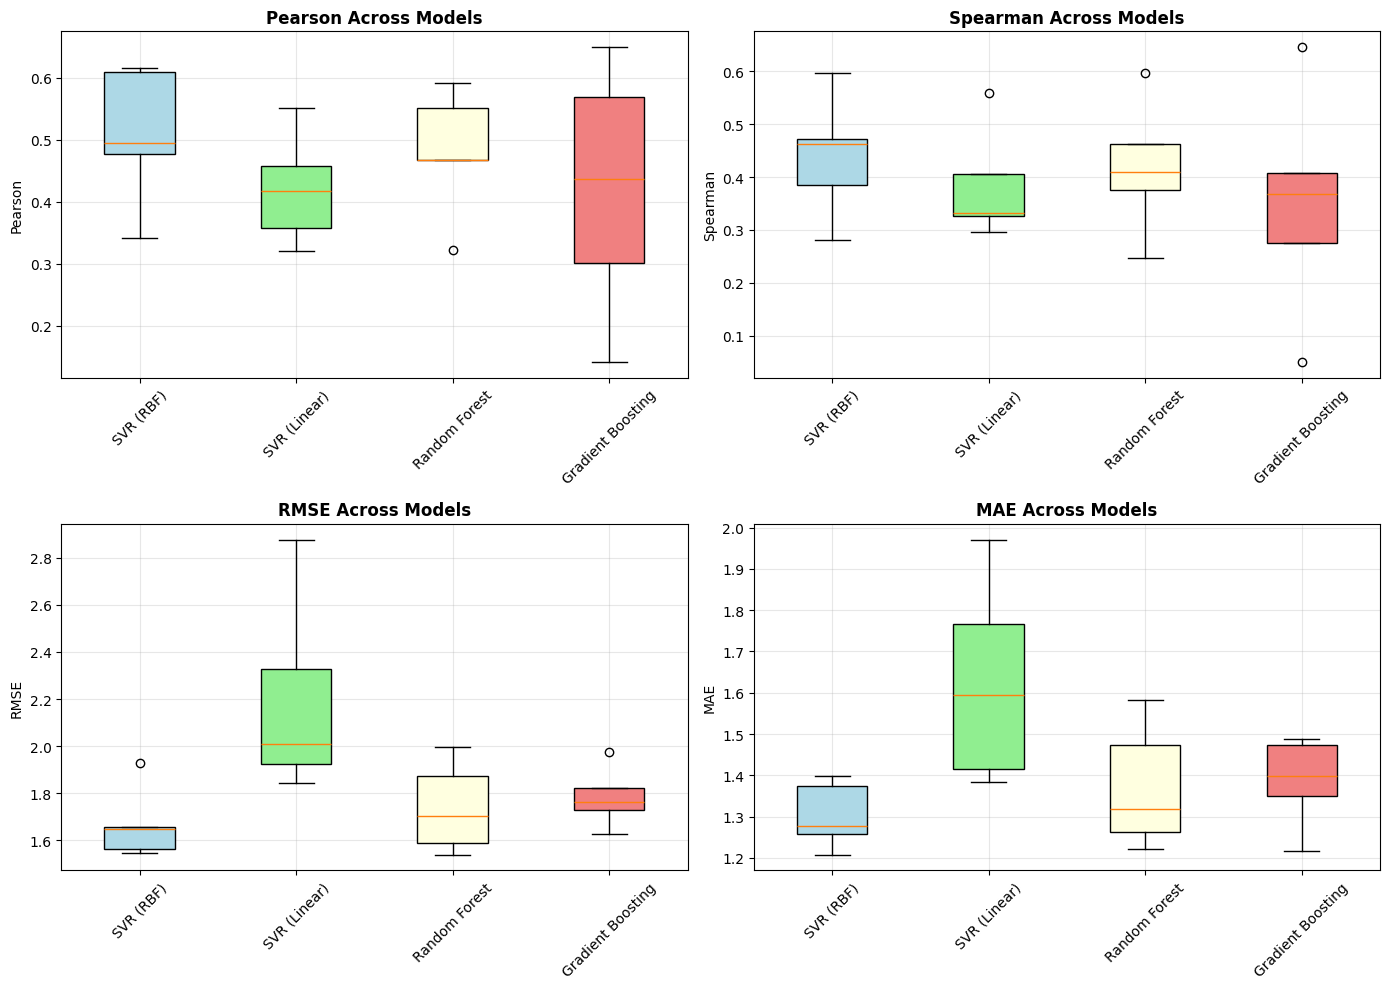

In [12]:
# ============================================================================
# PART 7: RESULTS VISUALIZATION
# ============================================================================

print("\n" + "="*70)
print("📊 RESULTS SUMMARY")
print("="*70 + "\n")

# Print detailed results for each model
for model_name, results_df in all_results.items():
    print(f"\n{model_name}:")
    print("-" * 60)
    print(results_df.to_string(index=False))
    print("\nMean ± Std:")
    summary = results_df.drop('Fold', axis=1).agg(['mean', 'std']).T
    print(summary.to_string())
    print("-" * 60)

# Comparison table
print("\n\n MODEL COMPARISON (Mean ± Std):")
print("="*70)

comparison = pd.DataFrame()
for model_name, results_df in all_results.items():
    stats = results_df.drop('Fold', axis=1).mean()
    comparison[model_name] = stats

print(comparison.round(4).T)

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics = ['Pearson', 'Spearman', 'RMSE', 'MAE']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]

    data_to_plot = []
    labels = []

    for model_name, results_df in all_results.items():
        data_to_plot.append(results_df[metric].values)
        labels.append(model_name)

    bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)

    # Color the boxes
    colors = ['lightblue', 'lightgreen', 'lightyellow', 'lightcoral']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    ax.set_title(f'{metric} Across Models', fontsize=12, fontweight='bold')
    ax.set_ylabel(metric)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('/content/model_comparison.png', dpi=300, bbox_inches='tight')
print("\n Visualization saved to /content/model_comparison.png")
plt.show()


🏆 Best Model: SVR (RBF)
   Average Pearson: 0.5078
   Average RMSE: 1.6699
✅ Prediction plot saved to /content/pred_vs_actual.png


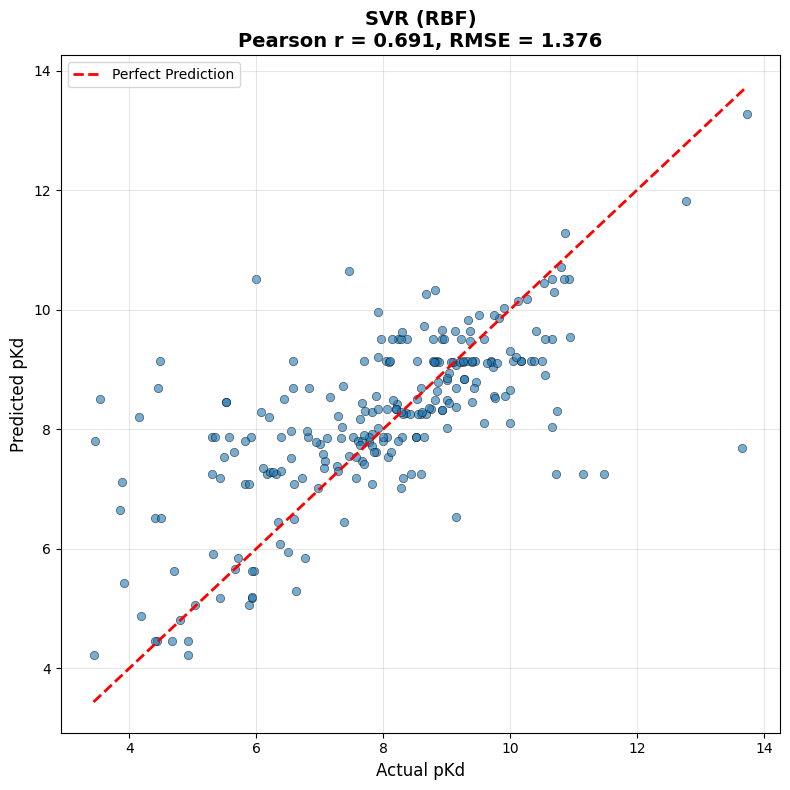


✨ ANALYSIS COMPLETE!


In [13]:
# ============================================================================
# PART 8: SAVE BEST MODEL PREDICTIONS
# ============================================================================

# Find best model by Pearson correlation
best_model_name = max(all_results.keys(),
                      key=lambda k: all_results[k]['Pearson'].mean())

print(f"\n Best Model: {best_model_name}")
print(f"   Average Pearson: {all_results[best_model_name]['Pearson'].mean():.4f}")
print(f"   Average RMSE: {all_results[best_model_name]['RMSE'].mean():.4f}")

# Train final model on all data for demonstration
final_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", models[best_model_name])
])

# For demonstration, do one final split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

final_pipeline.fit(X_train, y_train)
final_pred = final_pipeline.predict(X_test)

# Plot predicted vs actual
plt.figure(figsize=(8, 8))
plt.scatter(y_test, final_pred, alpha=0.6, edgecolors='k', linewidth=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', lw=2, label='Perfect Prediction')

corr = pearsonr(y_test, final_pred)[0]
rmse = np.sqrt(mean_squared_error(y_test, final_pred))

plt.xlabel('Actual pKd', fontsize=12)
plt.ylabel('Predicted pKd', fontsize=12)
plt.title(f'{best_model_name}\nPearson r = {corr:.3f}, RMSE = {rmse:.3f}',
          fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/content/pred_vs_actual.png', dpi=300, bbox_inches='tight')
print("Prediction plot saved to /content/pred_vs_actual.png")
plt.show()

print("\n" + "="*70)
print("ANALYSIS COMPLETE!")
print("="*70)